# 6.8 Final Project Ungraded Assessment
#### Names: Kristy Bell (kab7kr), Yayi Feng (yf7qq), MacKenzye Leroy (zuf9mc)
#### Topic: Loan Default - Lending Club

---
**Assignment Instructions**  
At this point in the course, you should be training and evaluating models and have saved at least one model. Please create a Jupyter Notebook containing a concise summary of at least one model. This should include:

- The type of model (e.g., logistic regression)
- Best hyperparameters used
- Size of the saved model
- And performance metrics

**Research Question:**
For our final project, we aim to investigate different attributes that may contribute to loan default and determine the most effective attributes in predicting loan default.

**Data Source:**
We found a dataset through Kaggle which comes from the world’s largest peer-to-peer lending platform, Lending Club. The data set consists of 153 attributes describing loan status of 2,925,494 loans (1.8 GB) from 2007-2020.  

---



In [1]:
import os
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.sql import functions as F
from pyspark.sql.functions import col, asc,when

from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml import Pipeline  
from pyspark.ml.feature import * 
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import IntegerType,BooleanType, FloatType, StringType

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
cwd = os.getcwd()


In [3]:
# Read data in csv format
df = spark.read.csv(f'{cwd}/Loan_status_2007_2020Q3.gzip',header=True,inferSchema=True)
df.count()

2925493

### Constructing Model 1: Predicting current vs late/default loans
As a company distributing loans and collecting loan payments, it is critical for LendingClub to know how much liquid cash they have available.  The more loans they can distibute, the higher profit they will make through interest rates (or taking a cut of what people are lending each other). Furthermore, it is important that LendingClub is able to accurately disclose the risk associated with a loan so that they are fully transparent with their investors. To dive into this problem, our first (main) model, is going to be a classificationn model where we are going to try to predict the "loan status" outcome variable. 

+---------------------------------------------------+-------+----+
|loan_status                                        |count  |prop|
+---------------------------------------------------+-------+----+
|Fully Paid                                         |1497783|0.51|
|Default                                            |433    |0.0 |
|In Grace Period                                    |10028  |0.0 |
|Does not meet the credit policy. Status:Fully Paid |1988   |0.0 |
|Charged Off                                        |362547 |0.12|
|Oct-2015                                           |1      |0.0 |
|Late (31-120 days)                                 |16154  |0.01|
|Issued                                             |2062   |0.0 |
|Current                                            |1031016|0.35|
|Does not meet the credit policy. Status:Charged Off|761    |0.0 |
|Late (16-30 days)                                  |2719   |0.0 |
+---------------------------------------------------+-------+-

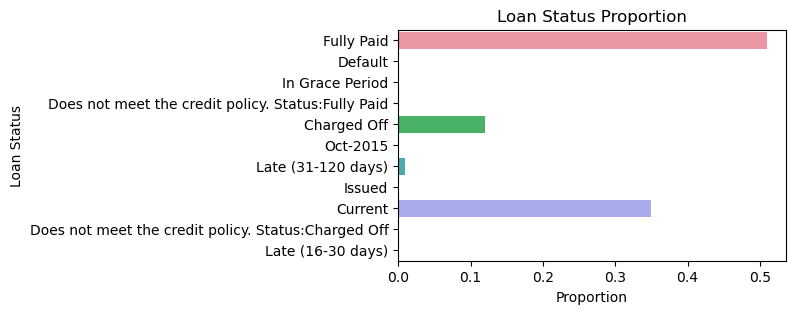

In [4]:
df = df.filter((col("loan_status")!="null")) # filter out value labeled as "null"
tot = df.count()
outcome_stats = df.groupBy("loan_status").count().\
        withColumn('prop', F.round((F.col('count') / tot),2))
outcome_stats.show(truncate=False)


outcome_stats = outcome_stats.toPandas()
plt.figure(figsize=(5,3))
sns.barplot(y='loan_status',x='prop',data=outcome_stats)
plt.ylabel('Loan Status')
plt.xlabel('Proportion')
plt.title('Loan Status Proportion')
plt.show()

Each loan status [explained](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-):  
- Fully paid: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment. (good)
- Default: Loan has not been current for an extended period of time. Learn more about the difference between “default” and “charge off”. (bad - down money)
- In Grace Period: Loan is past due but within the 15-day grace period. (fine - maybe risky)
- Charged Off: Loan for which there is no longer a reasonable expectation of further payments. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance. Learn more about the difference between “default” and “charge off”. (bad - down money)
- Late (16-30): Loan has not been current for 16 to 30 days. Learn more about the tools LendingClub has to deal with delinquent borrowers. (bad - down money)
- Issued: New loan that has passed all LendingClub reviews, received full funding, and has been issued. (fine - might want to filter out)
- Current: Loan is up to date on all outstanding payments. (good)
- Late (31-120): Loan has not been current for 31 to 120 days. Learn more about the tools LendingClub has to deal with delinquent borrowers. (bad - down money)

We are going to wrangle this column to create a binary outcome: 
- {1: LendingClub is out money}  
- {0: if the loan is current/paid}  

We decided to filter out "Issued" loans and "In Grace Period" as those are someone neutral outcomes (neither paid nor late).

In [5]:
df = df.filter((col("loan_status")!="Issued")) # issued means no payment yet
df = df.filter((col("loan_status")!="In Grace Period")) # in grace period means only 0 to 15 days

outcome_column = when((df.loan_status == "Default")|\
                      (df.loan_status == "Charged Off")|\
                      (df.loan_status == "Late (31-120 days)")|\
                      (df.loan_status == "Does not meet the credit policy. Status:Charged Off")|\
                      (df.loan_status ==  "Late (16-30 days)"), 1).otherwise(0)

df = df.withColumn("lose_money", outcome_column)
df.groupBy("lose_money").count().\
        withColumn('prop', F.round((F.col('count') / tot),2)).show(truncate=False)

+----------+-------+----+
|lose_money|count  |prop|
+----------+-------+----+
|1         |382614 |0.13|
|0         |2530788|0.87|
+----------+-------+----+



As expected, we have a data imbalance where the target class (default) appears only in 13% of observations. 

**Feature selecting, filtering, engineering**

In [6]:
# ---- Feature engineering: ------ #

# make new dti variable that combines individual dti as well as joint dti
df = df.withColumn('DTI', when(df.dti.isNull(), df.dti_joint).otherwise(df.dti))
# filter out strange (non numerical entries)
df = df.filter(df.DTI != 'WI')
df = df.filter(df.DTI != 'SC')

# similarly, make a new variable for annual income that combines
df = df.withColumn('ANNUAL_INC', when(df.annual_inc.isNull(), df.annual_inc_joint).otherwise(df.annual_inc))
df = df.filter(df.ANNUAL_INC != 'MORTGAGE') # filter out weird mortgage value



outcome_var = ["lose_money"]

categorical_vars = ["purpose", "term", "sub_grade","emp_length", \
                    "home_ownership","verification_status"]

numerical_vars = ["loan_amnt","DTI","last_fico_range_high", \
                  "total_pymnt","funded_amnt","funded_amnt_inv", \
                   "ANNUAL_INC","revol_bal"]

df = df.select(outcome_var+numerical_vars+categorical_vars)
df.show(2)

+----------+---------+-----+--------------------+---------------+-----------+---------------+----------+---------+-----------+----------+---------+----------+--------------+-------------------+
|lose_money|loan_amnt|  DTI|last_fico_range_high|    total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal|    purpose|      term|sub_grade|emp_length|home_ownership|verification_status|
+----------+---------+-----+--------------------+---------------+-----------+---------------+----------+---------+-----------+----------+---------+----------+--------------+-------------------+
|         0|     5000|27.65|                 704|5863.1551866952|       5000|         4975.0|     24000|    13648|credit_card| 36 months|       B2| 10+ years|          RENT|           Verified|
|         1|     2500|    1|                 499|        1014.53|       2500|         2500.0|     30000|     1687|        car| 60 months|       C4|  < 1 year|          RENT|    Source Verified|
+----------+---------+-----+--

In [7]:
df.count()

2913396

**Casting all features to the correct data type**

In [8]:
for var in categorical_vars:
    df = df.withColumn(var,df[var].cast(StringType()))
for var in numerical_vars:
    df = df.withColumn(var,df[var].cast(FloatType()))

In [9]:
df.dtypes

[('lose_money', 'int'),
 ('loan_amnt', 'float'),
 ('DTI', 'float'),
 ('last_fico_range_high', 'float'),
 ('total_pymnt', 'float'),
 ('funded_amnt', 'float'),
 ('funded_amnt_inv', 'float'),
 ('ANNUAL_INC', 'float'),
 ('revol_bal', 'float'),
 ('purpose', 'string'),
 ('term', 'string'),
 ('sub_grade', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('verification_status', 'string')]

In [10]:
list=["purpose", "term", "sub_grade","emp_length","home_ownership","verification_status","loan_amnt","DTI","last_fico_range_high", "total_pymnt","funded_amnt","funded_amnt_inv", "ANNUAL_INC","revol_bal"]
for i in list: 
    df.filter(col(i).isNull()).show() 

+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+-------+----+---------+----------+--------------+-------------------+
|lose_money|loan_amnt|DTI|last_fico_range_high|total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal|purpose|term|sub_grade|emp_length|home_ownership|verification_status|
+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+-------+----+---------+----------+--------------+-------------------+
+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+-------+----+---------+----------+--------------+-------------------+

+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+-------+----+---------+----------+--------------+-------------------+
|lose_money|loan_amnt|DTI|last_fico_range_high|total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal|p

**Split the data**

In [11]:
training, test = df.randomSplit([0.7, 0.3])

In [12]:
# one hot encode the categorical variables
stringIndexer_purpose = StringIndexer(inputCol="purpose", outputCol="purpose_index")
mod = stringIndexer_purpose.fit(training)
indexed = mod.transform(training)

stringIndexer_term = StringIndexer(inputCol="term", outputCol="term_index")
mod = stringIndexer_term.fit(indexed)
indexed = mod.transform(indexed)

stringIndexer_sub_grade = StringIndexer(inputCol="sub_grade", outputCol="sub_grade_index")
mod = stringIndexer_sub_grade.fit(indexed)
indexed = mod.transform(indexed)

#stringIndexer_emp = StringIndexer(inputCol="emp_length", outputCol="emp_index")
#mod = stringIndexer_emp.fit(indexed)
#indexed = mod.transform(indexed)

stringIndexer_home_ownership = StringIndexer(inputCol="home_ownership", outputCol="home_ownership_index")
mod = stringIndexer_home_ownership.fit(indexed)
indexed = mod.transform(indexed)

stringIndexer_verification_status = StringIndexer(inputCol="verification_status", outputCol="verification_status_index")
mod = stringIndexer_verification_status.fit(indexed)
indexed = mod.transform(indexed)

In [13]:
encoder = OneHotEncoder(inputCols=["purpose_index","term_index",
                                           "sub_grade_index",
                                          "home_ownership_index","verification_status_index"], 
                                outputCols=["purpose_ohe","term_ohe",
                                            "sub_grade_ohe",
                                           "home_ohe","verif_ohe"])
model = encoder.fit(indexed)
encoded = model.transform(indexed)

In [14]:
encoded.show(2)

+----------+---------+----+--------------------+-----------+-----------+---------------+----------+---------+--------+----------+---------+----------+--------------+-------------------+-------------+----------+---------------+--------------------+-------------------------+--------------+-------------+--------------+-------------+-------------+
|lose_money|loan_amnt| DTI|last_fico_range_high|total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal| purpose|      term|sub_grade|emp_length|home_ownership|verification_status|purpose_index|term_index|sub_grade_index|home_ownership_index|verification_status_index| sub_grade_ohe|    verif_ohe|   purpose_ohe|     term_ohe|     home_ohe|
+----------+---------+----+--------------------+-----------+-----------+---------------+----------+---------+--------+----------+---------+----------+--------------+-------------------+-------------+----------+---------------+--------------------+-------------------------+--------------+-------------+------

In [15]:
encoded.dtypes

[('lose_money', 'int'),
 ('loan_amnt', 'float'),
 ('DTI', 'float'),
 ('last_fico_range_high', 'float'),
 ('total_pymnt', 'float'),
 ('funded_amnt', 'float'),
 ('funded_amnt_inv', 'float'),
 ('ANNUAL_INC', 'float'),
 ('revol_bal', 'float'),
 ('purpose', 'string'),
 ('term', 'string'),
 ('sub_grade', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('verification_status', 'string'),
 ('purpose_index', 'double'),
 ('term_index', 'double'),
 ('sub_grade_index', 'double'),
 ('home_ownership_index', 'double'),
 ('verification_status_index', 'double'),
 ('sub_grade_ohe', 'vector'),
 ('verif_ohe', 'vector'),
 ('purpose_ohe', 'vector'),
 ('term_ohe', 'vector'),
 ('home_ohe', 'vector')]

In [16]:
res = encoded.drop('purpose','term','sub_grade','emp_length','home_ownership','verification_status',\
            'purpose_index','term_index','sub_grade_index','home_ownership_index','verification_status_index',)

In [17]:
res.dtypes

[('lose_money', 'int'),
 ('loan_amnt', 'float'),
 ('DTI', 'float'),
 ('last_fico_range_high', 'float'),
 ('total_pymnt', 'float'),
 ('funded_amnt', 'float'),
 ('funded_amnt_inv', 'float'),
 ('ANNUAL_INC', 'float'),
 ('revol_bal', 'float'),
 ('sub_grade_ohe', 'vector'),
 ('verif_ohe', 'vector'),
 ('purpose_ohe', 'vector'),
 ('term_ohe', 'vector'),
 ('home_ohe', 'vector')]

In [18]:
res.show(2)

+----------+---------+----+--------------------+-----------+-----------+---------------+----------+---------+--------------+-------------+--------------+-------------+-------------+
|lose_money|loan_amnt| DTI|last_fico_range_high|total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal| sub_grade_ohe|    verif_ohe|   purpose_ohe|     term_ohe|     home_ohe|
+----------+---------+----+--------------------+-----------+-----------+---------------+----------+---------+--------------+-------------+--------------+-------------+-------------+
|         0|    500.0|2.15|               539.0|   557.5353|      500.0|          375.0|   33000.0|   3461.0|(34,[9],[1.0])|(2,[1],[1.0])|(13,[3],[1.0])|(1,[0],[1.0])|(5,[1],[1.0])|
|         0|    500.0|3.04|               499.0|  580.46277|      500.0|          500.0|   7904.04|     44.0|(34,[1],[1.0])|(2,[1],[1.0])|(13,[8],[1.0])|(1,[0],[1.0])|(5,[0],[1.0])|
+----------+---------+----+--------------------+-----------+-----------+---------------+--

In [22]:
assembler = VectorAssembler(inputCols=["purpose_ohe","term_ohe",\
                               "sub_grade_ohe", \
                               "home_ohe","verif_ohe", \
                                       "loan_amnt","DTI","last_fico_range_high", \
                  "total_pymnt","funded_amnt","funded_amnt_inv", \
                   "ANNUAL_INC","revol_bal"
                                ], outputCol="feature_vector")  
vec = assembler.transform(res)

In [23]:
vec.show(1)

+----------+---------+----+--------------------+-----------+-----------+---------------+----------+---------+--------------+-------------+--------------+-------------+-------------+--------------------+
|lose_money|loan_amnt| DTI|last_fico_range_high|total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal| sub_grade_ohe|    verif_ohe|   purpose_ohe|     term_ohe|     home_ohe|      feature_vector|
+----------+---------+----+--------------------+-----------+-----------+---------------+----------+---------+--------------+-------------+--------------+-------------+-------------+--------------------+
|         0|    500.0|2.15|               539.0|   557.5353|      500.0|          375.0|   33000.0|   3461.0|(34,[9],[1.0])|(2,[1],[1.0])|(13,[3],[1.0])|(1,[0],[1.0])|(5,[1],[1.0])|(63,[3,13,23,49,5...|
+----------+---------+----+--------------------+-----------+-----------+---------------+----------+---------+--------------+-------------+--------------+-------------+-------------+-------

In [23]:
lr = LogisticRegression(labelCol='lose_money', featuresCol='feature_vector', maxIter=10, regParam=0.01)
lrModel = lr.fit(vec)

In [24]:
# one hot encode the categorical variables

va = VectorAssembler(inputCols=["purpose_ohe","term_ohe",\
                               "sub_grade_ohe", "emp_ohe",\
                               "home_ohe","verif_ohe",
                                "loan_amnt","DTI","last_fico_range_high", \
                  "total_pymnt","funded_amnt","funded_amnt_inv", \
                   "ANNUAL_INC","revol_bal"], outputCol="feature_vector")  

scalar = MinMaxScaler(inputCol="feature_vector",outputCol="features")
lr = LogisticRegression(labelCol='lose_money', featuresCol='features', maxIter=10, regParam=0.01)

**Build Pipeline**

In [115]:
# one hot encode the categorical variables
stringIndexer_purpose = StringIndexer(inputCol="purpose", outputCol="purpose_index")
stringIndexer_term = StringIndexer(inputCol="term", outputCol="term_index")
stringIndexer_sub_grade = StringIndexer(inputCol="sub_grade", outputCol="sub_grade_index")
#stringIndexer_emp = StringIndexer(inputCol="emp_length", outputCol="emp_index")
stringIndexer_home_ownership = StringIndexer(inputCol="home_ownership", outputCol="home_ownership_index")
stringIndexer_verification_status = StringIndexer(inputCol="verification_status", outputCol="verification_status_index")

encoder_purpose = OneHotEncoder(inputCol="purpose_index", outputCol="purpose_ohe")
encoder_term = OneHotEncoder(inputCol="term_index", outputCol="term_ohe")
encoder_sub = OneHotEncoder(inputCol="sub_grade_index", outputCol="sub_grade_ohe")
#encoder_emp = OneHotEncoder(inputCol="emp_index", outputCol="emp_ohe")
encoder_home = OneHotEncoder(inputCol="home_ownership_index", outputCol="home_ohe")
encoder_verif = OneHotEncoder(inputCol="verification_status_index", outputCol="verif_ohe")

va = VectorAssembler(inputCols=["purpose_ohe","term_ohe",\
                               "sub_grade_ohe", \
                               "home_ohe","verif_ohe",
                                "loan_amnt","DTI","last_fico_range_high", \
                  "total_pymnt","funded_amnt","funded_amnt_inv", \
                   "ANNUAL_INC","revol_bal"], outputCol="feature_vector")  

scalar = MinMaxScaler(inputCol="feature_vector",outputCol="features")

# Best model so far form hyperparamter tuning (by AUROC)
lr = LogisticRegression(labelCol='lose_money', featuresCol='features', maxIter=15, regParam=0.1)

In [116]:
# Fit the pipeline
pipeline = Pipeline(stages=[stringIndexer_purpose,\
                            stringIndexer_term,\
                            stringIndexer_sub_grade,\
                            # stringIndexer_emp,\
                            stringIndexer_home_ownership,\
                            stringIndexer_verification_status,\
                            encoder_purpose,\
                            encoder_term,\
                            encoder_sub,\
                            # encoder_emp, \
                            encoder_home,\
                            encoder_verif,\
                            va, scalar, lr]) 


In [117]:
model = pipeline.fit(training)

**Make predictions on the test set**

In [118]:
prediction = model.transform(test)
prediction.select('lose_money', 'probability','prediction').show(10, False)

+----------+-----------------------------------------+----------+
|lose_money|probability                              |prediction|
+----------+-----------------------------------------+----------+
|0         |[0.9454162646849293,0.05458373531507066] |0.0       |
|0         |[0.9334562081652567,0.06654379183474335] |0.0       |
|0         |[0.9415277411431728,0.058472258856827164]|0.0       |
|0         |[0.8173616095866689,0.18263839041333108] |0.0       |
|0         |[0.9232206472227381,0.07677935277726189] |0.0       |
|0         |[0.8749906668620008,0.12500933313799922] |0.0       |
|0         |[0.6547909606559129,0.3452090393440871]  |0.0       |
|0         |[0.8838507485373596,0.11614925146264043] |0.0       |
|0         |[0.9024205220999816,0.09757947790001842] |0.0       |
|0         |[0.9651640251941283,0.03483597480587175] |0.0       |
+----------+-----------------------------------------+----------+
only showing top 10 rows



In [119]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [120]:
evaluator = MulticlassClassificationEvaluator(
    labelCol='lose_money', 
    predictionCol='prediction', 
    metricName='accuracy')

In [121]:
accuracy = evaluator.evaluate(prediction)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.8910321248930162


In [122]:
evaluator2 = MulticlassClassificationEvaluator(
    labelCol='lose_money', 
    predictionCol='prediction', 
    metricName='precisionByLabel')

In [123]:
precision = evaluator2.evaluate(prediction)
print('Precision = ', precision)

Precision =  0.8906110118357883


In [124]:
evaluator3 = MulticlassClassificationEvaluator(
    labelCol='lose_money', 
    predictionCol='prediction', 
    metricName='recallByLabel')

In [125]:
recall = evaluator3.evaluate(prediction)
print('Recall = ', recall)

Recall =  0.9970394212648045
